## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
print(data['date'].min(), '-', data['date'].max())

2021-01-02 00:00:00 - 2021-01-24 00:00:00


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
# Считаем количество посещений в группах
a_count = data[data['group'] == 'A'].shape[0]
b_count = data[data['group'] == 'B'].shape[0]
print('В группе А {} посещений, в группе B {}.'.format(a_count, b_count))

# Считаем суммарное количество покупок в группах
a_purchases = data[data['group'] == 'A']['purchase'].sum()
b_purchases = data[data['group'] == 'B']['purchase'].sum()
print('В группе А {} покупок, в группе B {}.'.format(a_purchases, b_purchases))

# Считаем сумму всех покупок в группах
a_price = data[data['group'] == 'A']['price'].sum()/1000000
b_price = data[data['group'] == 'B']['price'].sum()/1000000
print('В группе А сумма всех покупок {} млн.руб., в группе B {} млн.руб..'.format(a_price, b_price))

В группе А 147202 посещений, в группе B 147276.
В группе А 17723 покупок, в группе B 17514.
В группе А сумма всех покупок 1436.26 млн.руб., в группе B 1554.1 млн.руб..


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [37]:
# Определяем количество ID в разных группах
a_set = set(data[data['group'] == 'A']['user_id'])
b_set = set(data[data['group'] == 'B']['user_id'])
user_intersection = a_set.intersection(b_set)

print('Количество ID:', len(user_intersection))


Количество ID: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [10]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

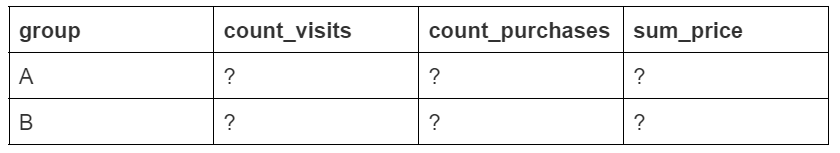
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [38]:
grouped_data = updated_data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})

grouped_data

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений сайта и количсетво покупок в группах практически одинаковое. В группе В общая сумма покупок несколько больше, что может говорить о более высокой эффективности второго варианта сайта. Для более обоснованного вывода требуются дополнительные исследования. 

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [39]:
grouped_data['conversion'] = round(grouped_data[
    'count_purchases']/grouped_data['count_visits']*100, 2)

grouped_data['mean_check'] = round(grouped_data[
    'sum_price']/grouped_data['count_purchases'])

grouped_data

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Показатели конверсии в группах существенно не отличаются. В группе В средний чек несколько выше, что может дополнительно говорить о большей эффективности второй версии сайта с точки зрения общей суммы продаж. Для более обоснованного вывода требуются дополнительные исследования. 

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [17]:
# Формируем сводную таблицу зависимости количества продаж от группы и цены тура
pivot_data = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
pivot_data

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

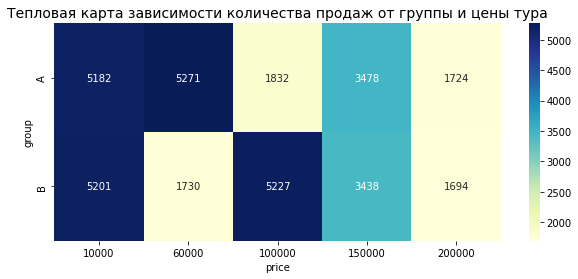

In [18]:
# Строим тепловую карту
fig = plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(
    data = pivot_data,
    annot=True,
    cmap='YlGnBu',
    fmt='.0f'
    )

heatmap.set_title(
    'Тепловая карта зависимости количества продаж от группы и цены тура', 
    fontsize = 14);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

По количеству туров в Санкт-Петербург, на Камчатку и на Мальдивы группы практически не отличаются. В группе А поездки в Турцию более популярны, чем в Таиланд. В группе В картина обратная: поездок в Таиланд сопоставимо больше, чем в Турцию. Тур в Таиланд стоит дороже тура в Турцию, этим можно объяснить более высокую сумму среднего чека в группе B.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [20]:
# Группируем данные по дате и группе
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})

# Добавляем признаки: конверсия и средний чек
daily_data['conversion'] = round(daily_data[
    'count_purchases']/daily_data['count_visits']*100, 2)

daily_data['mean_check'] = round(daily_data[
    'sum_price']/daily_data['count_purchases'])

print('Данные на 3 января 2021 года:')
daily_data.loc['2021-01-03'][['conversion', 'mean_check']]


Данные на 3 января 2021 года:


,conversion,mean_check
group,,
A,11.34,82888.0
B,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [21]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивное количество совершённых покупок
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = round(daily_data['cum_count_purchases']/
                                     daily_data['cum_count_visits']*100, 2)
# вычисляем кумулятивный средний чек
daily_data['cum_mean_check'] = round(daily_data['cum_sum_price']/
                                     daily_data['cum_count_purchases'])

print('Куммулятивная конверсия в группе В 21 января 2021 года:', 
      daily_data.loc['2021-01-20'].loc['B']['cum_conversion'])

print('Куммулятивный средний чек в группе А 12 января 2021 года:', 
      daily_data.loc['2021-01-12'].loc['A']['cum_mean_check'])

Куммулятивная конверсия в группе В 21 января 2021 года: 11.9
Куммулятивный средний чек в группе А 12 января 2021 года: 81492.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [22]:
daily_data.head()

count_visits  count_purchases  sum_price  conversion  \
date       group                                                         
2021-01-02 A              2854              359   29410000       12.58   
           B              2861              345   29660000       12.06   
2021-01-03 A              6596              748   62000000       11.34   
           B              6619              754   65960000       11.39   
2021-01-04 A              6566              799   64250000       12.17   

                  mean_check  cum_count_visits  cum_count_purchases  \
date       group                                                      
2021-01-02 A         81922.0              2854                  359   
           B         85971.0              2861                  345   
2021-01-03 A         82888.0              9450                 1107   
           B         87480.0              9480                 1099   
2021-01-04 A         80413.0             16016                 1906   

                  cum_sum_price  cum_conversion  cum_mean_check  
date       group                                                 
2021-01-02 A           29410000           12.58         81922.0  
           B           29660000           12.06         85971.0  
2021-01-03 A           91410000           11.71         82575.0  
           B           95620000           11.59         87006.0  
2021-01-04 A          155660000           11.90         81668.0

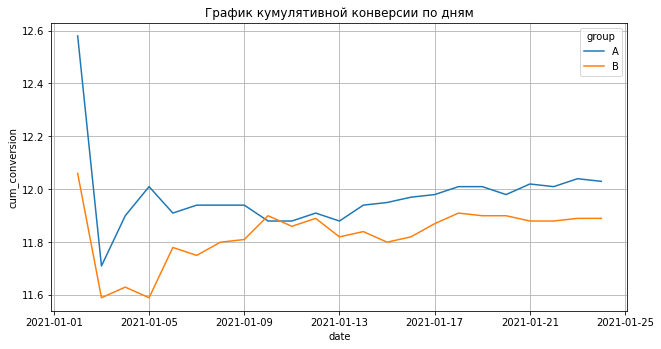

In [23]:
# График кумулятивной конверсии по дням
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))

# добавляем систему координат
plot = fig.add_axes([1, 1, 1, 1])

# строим lineplot для кумулятивной конверсии во времени в каждой группе
plot = sns.lineplot(
    x='date',                   
    y='cum_conversion',
    data=daily_data, hue='group', 
    ax=plot
    )
# задаём подпись к графику
plot.set_title('График кумулятивной конверсии по дням')
# задаём отображение сетки
plot.grid(True);

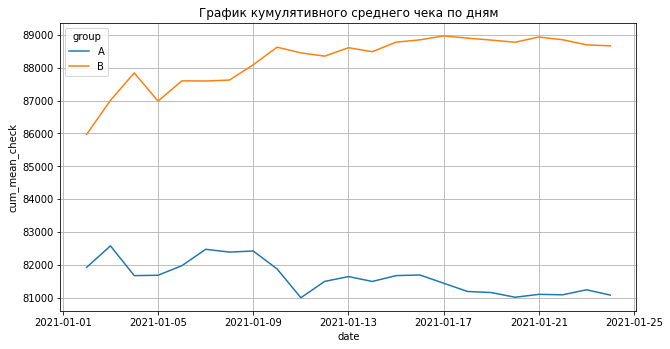

In [24]:
# График кумулятивного среднего чека по дням

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))

# добавляем систему координат
plot = fig.add_axes([1, 1, 1, 1])

# строим lineplot для кумулятивной конверсии во времени в каждой группе
plot = sns.lineplot(
    x='date',                   
    y='cum_mean_check',
    data=daily_data, hue='group', 
    ax=plot
    )
# задаём подпись к графику
plot.set_title('График кумулятивного среднего чека по дням')
# задаём отображение сетки
plot.grid(True);

Приблизительно после 10 янаваря графики по обоим признакам стабилизировались. После стабилизации на графике кумулятивной конверсии в группе А наблюдаются более высокие показатели. На графике кумулятивного среднего чека ситуация обратная: показатели в группе В выше, не смотря на более низкие показатели конверсии. Окончательный вывод по графикам сделать нельзя, поскольку результаты неоднозначные. 

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [27]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=grouped_data['count_purchases'], #число "успехов"
    nobs=grouped_data['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

По результатам z-теста можно сделать вывод, что нет существенной разницы между конверсиями в группах А и B. Мы принимаем нулевую гипотезу: конверсии в группах А и В равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [28]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group']=='A']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='A']['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group']=='B']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='B']['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [29]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [updated_data[updated_data['group']=='A']['user_id'].count(), 
     updated_data[updated_data['group']=='B']['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group']=='A']['purchase'].mean(), 
      updated_data[updated_data['group']=='B']['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы для групп близки по своим значениям и практически полностью перекрывают друг друга. Доверительный интервал для разницы конверсии охватывает точку 0. Все это говорит о равнозначности групп А и В по метрике конверсии. 

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [40]:
daily = daily_data.reset_index()


In [31]:
# нулевая и альтернативная гипотезы
H0 = 'Распределение в группе нормальное'
H1 = 'Распределение в группе отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily[daily['group'] =='A']['mean_check'])
shapiro_result_b = shapiro(daily[daily['group'] =='B']['mean_check'])
print('p-value группы А: ', round(shapiro_result_a.pvalue, 3))
print('p-value группы B: ', round(shapiro_result_b.pvalue, 3))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha:
    print("Группа А. Отвергаем нулевую гипотезу. {}".format(H1))
else:
    print("Группа А. Принимаем нулевую гипотезу. {}".format(H0))
    
if shapiro_result_b.pvalue < alpha:
    print("Группа В. Отвергаем нулевую гипотезу. {}".format(H1))
else:
    print("Группа В. Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А:  0.253
p-value группы B:  0.094
Группа А. Принимаем нулевую гипотезу. Распределение в группе нормальное
Группа В. Принимаем нулевую гипотезу. Распределение в группе нормальное


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [33]:
# нулевая и альтернативная гипотезы
H0 = 'Средние чеки в группах А и B равны.'
H1 = 'Средний чек в группе А меньше, чем в группе B.'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для теста mannwhitneyu
_, p_value = ttest_ind(
    
    daily[daily['group']=='A']['mean_check'],
    daily[daily['group']=='B']['mean_check'],
    alternative = 'less'
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу. Средний чек в группе А меньше, чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

По результатам Т-теста можно сделать вывод, что статистическая разница между средними чеками в группах есть. В группе В этот показатель выше.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [34]:
daily.tail()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
41,2021-01-22,B,6659,787,68660000,11.82,87243.0,135071,16043,1425430000,11.88,88851.0
42,2021-01-23,A,6698,843,70950000,12.59,84164.0,141541,17043,1384530000,12.04,81237.0
43,2021-01-23,B,6633,805,68930000,12.14,85627.0,141704,16848,1494360000,11.89,88697.0
44,2021-01-24,A,3766,444,33250000,11.79,74887.0,145307,17487,1417780000,12.03,81076.0
45,2021-01-24,B,3677,442,38650000,12.02,87443.0,145381,17290,1533010000,11.89,88665.0


In [35]:
daily[daily['group']=='A']['mean_check'].std()

3096.388506406891

In [36]:
# Группа А
n = daily[daily['group']=='A'].shape[0]
k = n - 1 # число степеней свободы
x_mean = daily[daily['group']=='A']['mean_check'].mean() # выборочное среднее
x_std = daily[daily['group']=='A']['mean_check'].std()
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое
t_crit

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для группы А: {}'.format(confidence_interval)) # выводим результат


# Группа В
n = daily[daily['group']=='B'].shape[0]
k = n - 1 # число степеней свободы
x_mean = daily[daily['group']=='B']['mean_check'].mean() # выборочное среднее
x_std = daily[daily['group']=='B']['mean_check'].std()
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое
t_crit

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для группы В: {}'.format(confidence_interval)) # выводим результат
 

Доверительный интервал для группы А: (79630, 82308)
Доверительный интервал для группы В: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы для ежедневных средних чеков групп не пересекаются. Значения доверительного интервала группы В выше соответствующих значения для группы А. Из этого можно сделать вывод, что ежедневный средний чек в группе В выше. 

## **Общий вывод по результатам A/B-теста**

По результатам A/B-теста можно сделать следующие выводы: 
1. На количество продаж (конверсию) второй вариант посадочной страницы официального сайта компании существенного влияния не оказал. Наоборот, наблюдается незначительное отрицательное влияние. Если задача кампании увеличить число продаж, то внедрение второго варианта сайта не будет оправдано.
2. Второй вариант сайта более эффективен с точки зрения средней суммы покупки или общей суммы продаж. Это обусловлено тем, что пользователи этого варианта сайта предпочитают более дорогой тур в Таиланд менее дорогому туру в Турцию. Второй вариант сайта будет оправдан в целях увеличения среднего чека и общей суммы продаж. 
